# Parking Space Detection
---





**1. Get datasets (zip) file from google drive and unzip it**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/dataset/Parking.v1i.tensorflow.zip > /dev/null

**2. Clone my github repo and copy a python script module**

In [3]:
!git clone https://github.com/beizerore/SmartParking-ML.git
!cp /content/SmartParking-ML/object_detection/generatedata.py /content/
!cp /content/SmartParking-ML/object_detection/templatemodel.py /content/

Cloning into 'SmartParking-ML'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 68 (delta 17), reused 38 (delta 16), pack-reused 28
Unpacking objects: 100% (68/68), done.


**3. Import modules and dependencies**

In [45]:
import cv2
import os
import tensorflow as tf
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import templatemodel

from generatedata import Filename, Images, Label, Keypoints, Annotations
from templatemodel import Preprocess, Model, Plot

**4. Preprocess the datasets**

In [5]:
# read csv to pandas dataframe
req_images = pd.read_csv('train/_annotations.csv')
req_images.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,2013-03-17_17_15_13_jpg.rf.63df560223c410618de...,416,416,space-empty,197,304,252,378
1,2013-03-17_17_15_13_jpg.rf.63df560223c410618de...,416,416,space-empty,176,254,226,312
2,2013-03-17_17_15_13_jpg.rf.63df560223c410618de...,416,416,space-empty,159,212,203,264
3,2013-03-17_17_15_13_jpg.rf.63df560223c410618de...,416,416,space-empty,145,175,186,223
4,2013-03-17_17_15_13_jpg.rf.63df560223c410618de...,416,416,space-empty,133,146,170,183


In [6]:
# convert class to 0 and 1 label and add to a list
labels = Label(0, req_images['class'])
labels[:5]

['space-empty', 'space-occupied', 'space-occupied', 'space-occupied', 'space-occupied']


array([0., 1., 1., 1., 1.], dtype=float32)

In [7]:
# filter the duplicated filename (images), create its path, and add to a list
filenames = Filename(req_images['filename'])
filenames[:5]

images not duplicated: 2866


['train/2013-03-17_17_15_13_jpg.rf.63df560223c410618de6b0580e15b7af.jpg',
 'train/2013-03-14_07_20_01_jpg.rf.63e1888020c2c91aed26867135f16010.jpg',
 'train/2013-03-19_09_40_04_jpg.rf.647991c051ccf1114b68d53277e89840.jpg',
 'train/2013-03-14_14_36_02_jpg.rf.64417b42b58835958e3f70a1563c61f4.jpg',
 'train/2013-04-14_15_20_10_jpg.rf.63ef331a6e5fd06436272b8d6e64e449.jpg']

In [8]:
# generate images (array) and source/path from images 
model_input_images, source_images = Images(filenames)

images_shape: (2866, 96, 96, 3)


In [9]:
# resize keypoints ratio
req_images['width_ratio'] = req_images['width']/96
req_images['height_ratio'] = req_images['height']/96
req_images['xmin'] = req_images['xmin']/req_images['width_ratio']
req_images['xmax'] = req_images['xmax']/req_images['width_ratio']
req_images['ymin'] = req_images['ymin']/req_images['height_ratio']
req_images['ymax'] = req_images['ymax']/req_images['height_ratio']

In [10]:
#generate keypoints
model_input_keypoints = Keypoints(req_images, source_images)

In [11]:
print(len(model_input_keypoints))
print(model_input_keypoints[:40])

2866
[[0.46875    0.7291667  0.6041667  0.90625   ]
 [0.41666666 0.6041667  0.5416667  0.75      ]
 [0.375      0.5        0.47916666 0.625     ]
 [0.34375    0.41666666 0.4375     0.53125   ]
 [0.3125     0.34375    0.40625    0.4375    ]
 [0.29166666 0.27083334 0.38541666 0.36458334]
 [0.26041666 0.21875    0.34375    0.29166666]
 [0.23958333 0.15625    0.3125     0.22916667]
 [0.22916667 0.11458334 0.30208334 0.17708333]
 [0.21875    0.0625     0.28125    0.125     ]
 [0.5625     0.65625    0.6666667  0.7916667 ]
 [0.48958334 0.5520833  0.6041667  0.6666667 ]
 [0.46875    0.44791666 0.5625     0.5520833 ]
 [0.41666666 0.36458334 0.5208333  0.45833334]
 [0.39583334 0.29166666 0.48958334 0.375     ]
 [0.36458334 0.22916667 0.45833334 0.3125    ]
 [0.34375    0.17708333 0.41666666 0.25      ]
 [0.3125     0.11458334 0.39583334 0.19791667]
 [0.29166666 0.08333334 0.36458334 0.14583333]
 [0.27083334 0.04166667 0.34375    0.10416666]
 [0.84375    0.46875    0.9166667  0.5833333 ]
 [0.7812

In [12]:
# make a directory for processed images and plotted images
plt_dir = 'plt_images'
img_dir = 'images'

os.mkdir(img_dir)
os.mkdir(plt_dir)
os.makedirs(os.path.join(plt_dir, 'empty'))
os.makedirs(os.path.join(plt_dir, 'occupied'))

In [13]:
from PIL import Image

In [14]:
# save processed images to images dir
for index, image in enumerate(model_input_images):  
  hm = Image.fromarray(image)
  hm.save("images/{}.jpg".format(index))

In [15]:
# initialize first space keypoints
key = model_input_keypoints[0]*96
key

array([45., 70., 58., 87.], dtype=float32)

In [16]:
startX, endX = int(key[0]), int(key[1])
startY, endY = int(key[2]), int(key[3])

In [17]:
# save plotted image into 2 directory (empty and occupied) for labelling image
for index in range(len(model_input_images)):
  if labels[index] == 0: #if empty
    image = cv2.imread('images/{}.jpg'.format(index))
    out = cv2.rectangle(image, (startX, endX), (startY, endY), (255,0,0), 1)
    plt.imsave('plt_images/empty/empty_{}.jpg'.format(index), image)
  else:
    image = cv2.imread('images/{}.jpg'.format(index))
    out = cv2.rectangle(image, (startX, endX), (startY, endY), (255,0,0), 1)
    plt.imsave('plt_images/occupied/occupied_{}.jpg'.format(index), image)

In [18]:
print(len(os.listdir('plt_images/empty')))
print(len(os.listdir('plt_images/occupied')))

1066
1800


**5. Build Image Classification Model**

Found 2866 files belonging to 2 classes.
Using 2293 files for training.
Found 2866 files belonging to 2 classes.
Using 573 files for validation.
class names : ['empty', 'occupied']
image_batch shape: (32, 96, 96, 3)
label_batch shape: (32,)
normalization: 0.0 1.0


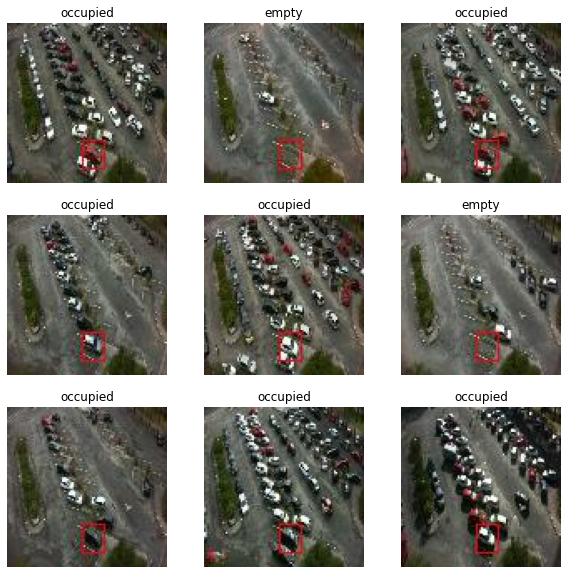

In [20]:
# preprocess the plotted image for model training/validation
train_ds, val_ds, class_names = Preprocess(plt_dir)

In [41]:
# initialize model
model = Model(class_names)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        1

In [40]:
# MODEL RESET ONLY FOR RESTART THE TRAINING HISTORY PURPOSE
# ---------------------------------------------------------

# tf.keras.backend.clear_session()
# import random
# import keras.backend as K

# def reset_seeds():
#     np.random.seed(1)
#     random.seed(2)
#     if tf.__version__[0] == '2':
#         tf.random.set_seed(3)
#     else:
#         tf.set_random_seed(3)
#     print("RANDOM SEEDS RESET")

# del model
# K.clear_session()
# tf.compat.v1.reset_default_graph()

# reset_seeds()

RANDOM SEEDS RESET


In [42]:
# train model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
72/72 [==============================] - 1s 11ms/step - loss: 0.2199 - accuracy: 0.9158 - val_loss: 0.0686 - val_accuracy: 0.9825
Epoch 2/10
72/72 [==============================] - 1s 8ms/step - loss: 0.0582 - accuracy: 0.9826 - val_loss: 0.0315 - val_accuracy: 0.9878
Epoch 3/10
72/72 [==============================] - 1s 9ms/step - loss: 0.0174 - accuracy: 0.9943 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 4/10
72/72 [==============================] - 1s 9ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 0.0140 - val_accuracy: 0.9948
Epoch 5/10
72/72 [==============================] - 1s 8ms/step - loss: 0.0177 - accuracy: 0.9952 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 6/10
72/72 [==============================] - 1s 8ms/step - loss: 6.2138e-04 - accuracy: 1.0000 - val_loss: 3.9818e-04 - val_accuracy: 1.0000
Epoch 7/10
72/72 [==============================] - 1s 9ms/step - loss: 1.8304e-04 - accuracy: 1.0000 - val_loss: 1.8013e-04 - val_accuracy: 1.0000
Epo

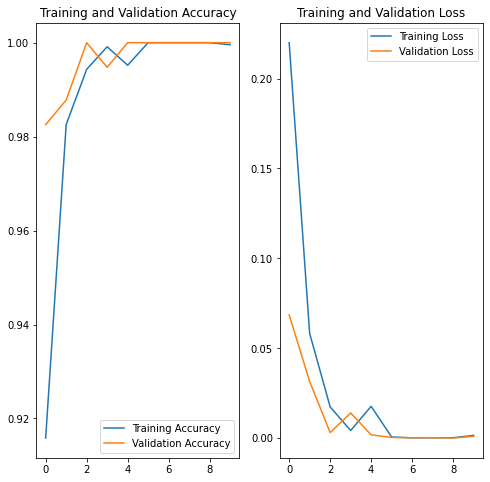

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# plot the metrics
Plot(acc, val_acc, loss, val_loss, epochs)

**6. Model Testing and Predictions**

In [58]:
# OCCUPIED EXAMPLE

img_test_path1 = '/content/test/2013-02-22_11_15_05_jpg.rf.affe125ec6d2c273462c1620bb274411.jpg'
img1 = tf.keras.utils.load_img(
    img_test_path1, target_size=(templatemodel.img_height, templatemodel.img_width)
)
img_array1 = tf.keras.utils.img_to_array(img1)
img_array1 = tf.expand_dims(img_array1, 0) # Create a batch

predictions1 = model.predict(img_array1)
score1 = tf.nn.softmax(predictions1[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score1)], 100 * np.max(score1))
)

This image most likely belongs to occupied with a 99.99 percent confidence.


In [59]:
# EMPTY EXAMPLE

img_test_path2 = '/content/test/2013-03-02_08_35_03_jpg.rf.d64a145f2d85b23e1e5f989f40bb88d5.jpg'
img2 = tf.keras.utils.load_img(
    img_test_path2, target_size=(templatemodel.img_height, templatemodel.img_width)
)
img_array2 = tf.keras.utils.img_to_array(img2)
img_array2 = tf.expand_dims(img_array2, 0) # Create a batch

predictions2 = model.predict(img_array2)
score2 = tf.nn.softmax(predictions2[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score2)], 100 * np.max(score2))
)

This image most likely belongs to empty with a 100.00 percent confidence.


In [60]:
# get default ratio of keypoints
get_ann = pd.read_csv('train/_annotations.csv')
annotations = Annotations(get_ann, source_images)
annotations[0]

[197, 304, 252, 378]

Text(0.5, 1.0, 'Empty Space')

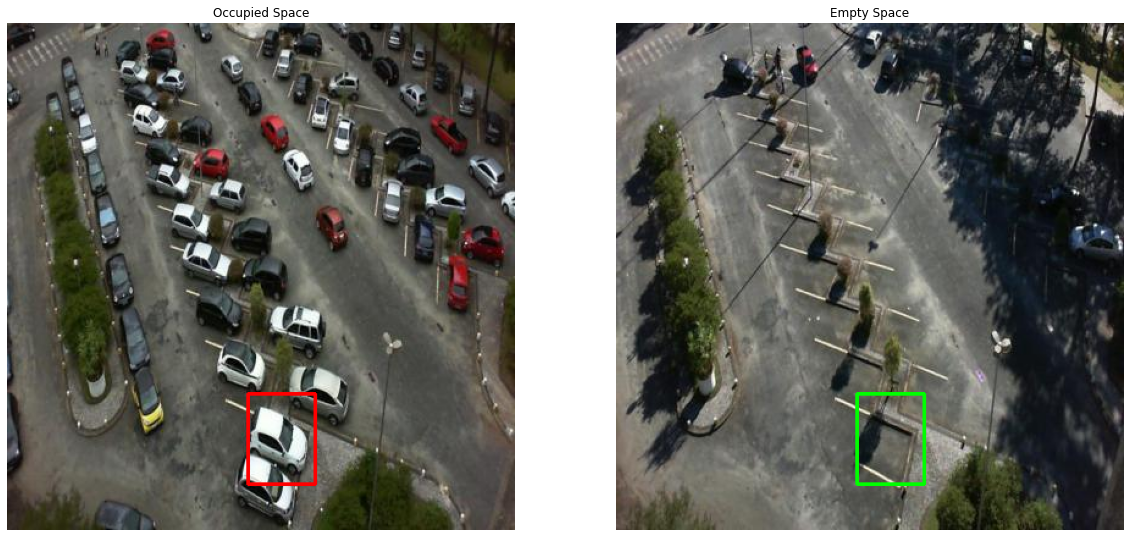

In [74]:
# plot the test
fig = plt.figure(figsize=(20, 20))

result_image1 = cv2.imread(img_test_path1)
result_image1 = cv2.cvtColor(result_image1, cv2.COLOR_BGR2RGB)
result_image2 = cv2.imread(img_test_path2)
result_image2 = cv2.cvtColor(result_image2, cv2.COLOR_BGR2RGB)

result_images = [result_image1, result_image2]
scores = [score1, score2]
for index, result in enumerate(result_images):
  if class_names[np.argmax(scores[index])] == 'occupied':
    occupied = cv2.rectangle(result, (annotations[0][0], annotations[0][1]), (annotations[0][2], annotations[0][3]), (255,0,0), 2)
  else:
    empty = cv2.rectangle(result, (annotations[0][0], annotations[0][1]), (annotations[0][2], annotations[0][3]), (0,255,0), 2)

fig.add_subplot(1, 2, 1)
plt.imshow(occupied)
plt.axis('off')
plt.title("Occupied Space")

fig.add_subplot(1, 2, 2)
plt.imshow(empty)
plt.axis('off')
plt.title("Empty Space")

In [49]:
# save model to h5 extension
import time
saved_model_path = "./1_space_detection_{}.h5".format(int(time.time()))

model.save(saved_model_path)